In [1]:
from ml_model_forward import ForwardTMMModel
import pandas as pd
from sklearn.model_selection import train_test_split

training_data = pd.read_csv("R.csv")

data_train, data_test = train_test_split(training_data, test_size=0.1)

model = ForwardTMMModel(serialised_model_path="forward_model")

2023-06-20 00:28:17.801070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 00:28:17.866831: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 00:28:17.868021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 00:28:19.223589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model.is_trained

True

In [4]:
feature_cols = ["d1", "d2", "d3", "d4", "d5", "d6", "First Layer", "Second Layer"]
if not model.is_trained:
    history = model.train(data_train[feature_cols], data_train[[c for c in data_train.columns if c not in feature_cols]], epochs=10)

In [6]:
import matplotlib.pyplot as plt

In [5]:
model.save("forward_model")

2023-06-20 00:25:39.600082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype string and shape [?,2]
	 [[{{node input_2}}]]
2023-06-20 00:25:39.821759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype string and shape [?,2]
	 [[{{node input_2}}]]
2023-06-20 00:25:39.987006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype string and shape [?,2]
	 [[{{node inputs_1}}]]
2023-06-20 

INFO:tensorflow:Assets written to: forward_model/assets


INFO:tensorflow:Assets written to: forward_model/assets


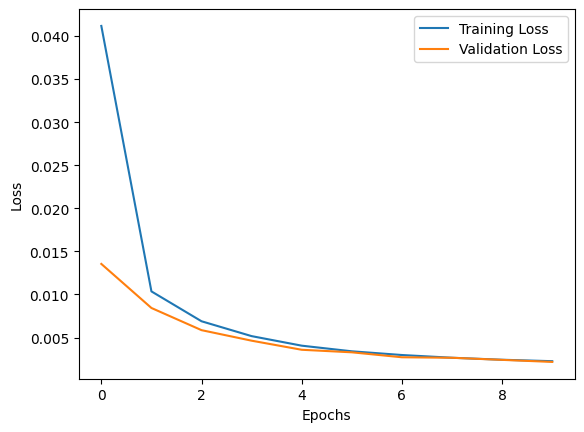

In [6]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step


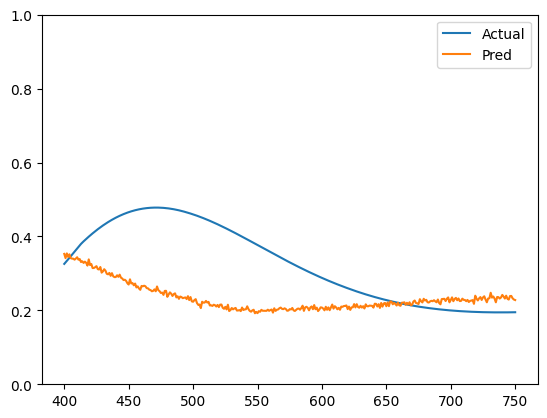

In [12]:
import random
import numpy as np
# Select a random index from the test set
index = random.randint(0, len(data_test[feature_cols]) - 1)
# index = 2849

# Get the corresponding input and output values
input_sample = data_test[feature_cols].iloc[[index]]
output_sample = data_test[[c for c in data_test.columns if c not in feature_cols]].iloc[[index]]

# Make a prediction for the selected sample
prediction = model.predict(input_sample)
output_sample = np.squeeze(output_sample)
prediction = np.squeeze(prediction)
fig,ax = plt.subplots()
x = np.arange(400,751)
ax.plot(x, output_sample, label='Actual')
ax.plot(x, prediction, label='Pred')
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [11]:
model.save("forward_model")

2023-06-20 00:26:26.081496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype string and shape [?,2]
	 [[{{node input_2}}]]
2023-06-20 00:26:26.502525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype string and shape [?,2]
	 [[{{node input_2}}]]
2023-06-20 00:26:26.696646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype string and shape [?,2]
	 [[{{node inputs_1}}]]
2023-06-20 

INFO:tensorflow:Assets written to: forward_model/assets


INFO:tensorflow:Assets written to: forward_model/assets


In [15]:
model.save("model.tf")

2023-06-20 00:31:55.342012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype string and shape [?,2]
	 [[{{node input_2}}]]
2023-06-20 00:31:55.674516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype string and shape [?,2]
	 [[{{node input_2}}]]
2023-06-20 00:31:55.849921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype string and shape [?,2]
	 [[{{node inputs_1}}]]
2023-06-20 

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets
